<a href="https://colab.research.google.com/github/GohNgeeJuay/AIAssistedOnlinePsychotherapyPortal/blob/main/Documented_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will explain the steps we did for the Deep Learning FER. 

The dataset which we will be using is from Khan et al:

1) https://link.springer.com/chapter/10.1007/978-3-319-27863-6_28
Automatic Affect Analysis: From Children to Adults.
Rizwan Ahmed Khan, Alexandre Meyer, Saida Bouakaz.
International Symposium on Visual Computing: ISVC 2015.

This dataset contains the children images which we are going to use for our training. 


We will also use Keras-VGGFace2-ResNet50 trained model for our fine tuning stage.

2) From: https://github.com/WeidiXie/Keras-VGGFace2-ResNet50. 
Cao18,
author       = "Q. Cao, L. Shen, W. Xie, O. M. Parkhi, A. Zisserman ",
title        = "VGGFace2: A dataset for recognising face across pose and age",
booktitle    = "International Conference on Automatic Face and Gesture Recognition, 2018.",
year         = "2018",


The architecture for our DL is inspired by:

3) Kuo, C., Lai, S., & Sarkis,M. (2018). A Compact Deep Learning Model for Robust Facial Expression Recognition. *2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), 2018*, 2202-2210, doi: 10.1109/CVPRW.2018.00286.

First steps are to preprocess the dataset for our use case. 

#1) Preprocessing

We worked collaboratively, so we store the dataset in our shared drive. Any work that we do in this shared google colab is sync with our shared drives

In [ ]:
#Sometimes need to flush and unmount to refresh the files in google colab
from google.colab.drive import flush_and_unmount
flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
#Reference https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory
#Mount the drive to access the files
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


We can also enable the google colab's gpu. Unfortunately this GPU is limited so we used GPULab for our training stage.

In [ ]:
import tensorflow as tf #Make sure GPU is enabled
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 1.1) Load and and investigate format of the input data

Next we need to investigate the data to see what we are working with.

In [ ]:
#Import libraries and check version
import sys
import cv2
print(cv2.__version__)
print(sys.version)
import pathlib
import os
import numpy as np


4.1.2
3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]


In [ ]:
#Load the video from the drive
test_video = cv2.VideoCapture('/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/LIRISChildrenSpontaneousFacialExpressionVideoDatabase/LIRISChildrenSpontaneousFacialExpressionVideoDatabase/videos_208/S1_disgust_1.mp4')

In [ ]:
# Find the number of frames for the test video
video_length = int(test_video.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
print ("Number of frames: ", video_length)

Number of frames:  197


## 1.2) Split the video into frames

We will input the video as still frames (pictures) into the network. Frames are extracted every 1/6 second.

In [ ]:
#Function to split the video into frames
#Reference: https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
def extractImages(pathIn, pathOut):
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()    #Grabs, decodes and returns the next video frame.
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*167))    # added this line. set() = set a property in video capture #0.167 for 6 frames per sec
        #CAP_PROP_POS_MSEC = Current position of the video file in milliseconds.
        success,image = vidcap.read()
        #print ('Read a new frame: ', success)
        if success == True:    #If have read in a new frame
          cv2.imwrite( pathOut + "/frame_%d_.jpg" % count, image)     # THE CHANGE IS HERE
        count = count + 1

We will call the function above and slice our images and store it in our drive folder. 

In [ ]:
#Loop through video folder and create the sliced images
#Reference: https://newbedev.com/how-to-iterate-over-files-in-a-given-directory
directory = "/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/LIRISChildrenSpontaneousFacialExpressionVideoDatabase/LIRISChildrenSpontaneousFacialExpressionVideoDatabase/videos_208"
for videoName in os.listdir(directory):

  sourceVideoDirectory = os.path.join(directory, videoName) 
  targetVideoDirectory = os.path.join("/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/SlicedImages/", videoName)
  
  #Create the target video directory if does not exist. Reference: https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-nested-directory-in-python
  pathlib.Path(targetVideoDirectory).mkdir(parents=True, exist_ok=True)

  #Split the video into frames. 
  extractImages(sourceVideoDirectory, targetVideoDirectory)

  print("Done processing" + str(videoName))


We also tried to see if we can removed the neutral expression frames from the videos. Given that LIRIS-CSE contains videos that are not peak expression, it might contain frames where there are neutral expression. 

This is not used because the FER used here failed to detect expressions. Possible reasons could include that these FER are trained on posed and peak expressions. We will just proceed with the next preprocessing step.

In [ ]:
#Testing whether can only get the faces with the desired emotion in the frames. 
#Reference: https://analyticsindiamag.com/face-emotion-recognizer-in-6-lines-of-code/
!pip install fer

In [ ]:
from fer import FER
import matplotlib.pyplot as plt 
import os

rootdir = "/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/Backup/S1_disgust_1.mp4"
for subdir, dirs, files in os.walk(rootdir):
  for file in files:
    print(file)
    img = plt.imread(os.path.join(subdir,file))
    detector = FER(mtcnn=True)
    print(detector.detect_emotions(img))
    plt.imshow(img)


In [ ]:
rootdir = "/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/Images/S5_surprise_1.mp4"
for subdir, dirs, files in os.walk(rootdir):
  for file in files:
    print(file)
    img = plt.imread(os.path.join(subdir,file))
    detector = FER(mtcnn=True)
    print(detector.detect_emotions(img))
    plt.imshow(img)

#1.2) Extracting face from image and resizing

Next, we will extract the faces from the sliced images and resize them to fit the input of our network. The face extraction should help eliminate the background which can improve the accuracy. 

The trained network we are using takes input of (224,224,3) which means each image needs to have height of 224, width of 224 and it has 3 channels (rgb color). 

In [ ]:
#Reference: https://www.geeksforgeeks.org/cropping-faces-from-images-using-opencv-python/
#Kuo et al used alpha = 1.05 for extracting faces
from google.colab.patches import cv2_imshow
def extract_face_2(image_path, destination_path, min_size):
  '''
  image_path = Path to the image to extract the image
  destination_path = Path to the destination where the extracted image will be stored 
  '''

  img = cv2.imread(image_path)

  # Convert into grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  

  faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.05, minNeighbors = 5, minSize= min_size )
  for (x, y, w, h) in faces:
    faces = img[y:y + h, x:x + w]
    cv2.imwrite(destination_path, faces)
  

In [ ]:
#Extract the faces from all the images
rootSourceDir = "/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/SlicedImages"
rootTargetDir = rootSourceDir+"Extracted"

pathlib.Path(rootTargetDir).mkdir(parents=True, exist_ok=True) 

flag = False

for subdir, dirs, files in os.walk(rootSourceDir):
  if "S12" in subdir or "S11" in subdir or "S4" in subdir: 
    flag = True

  for file in files:
    
    #Get the folder name only. Reference: https://www.studytonight.com/python-howtos/how-to-get-the-last-part-of-the-path-in-python
    folderName = os.path.basename(os.path.normpath(subdir))

    #Make the target folder if does not exist
    targetFolder = os.path.join(rootTargetDir, folderName)
    if os.path.isdir(targetFolder) == False:
      pathlib.Path(targetFolder).mkdir(parents=True, exist_ok=True) 

    # Detect faces (S12, S11, S4 uses minSize = (200,200), rest use minSize = (150, 150)). Some subjects require different parameters. 
    if flag == True:
      extract_face_2(os.path.join(subdir,file), os.path.join(targetFolder, file), (200,200))
    else:
      extract_face_2(os.path.join(subdir,file), os.path.join(targetFolder, file), (150,150))



In [ ]:
#Resizing all the images to 224x224 (required to input into the trained neural network)

#Reference: https://pythonexamples.org/python-opencv-cv2-resize-image/
rootSourceDir = "/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/SlicedImagesExtracted"
rootTargetDir = rootSourceDir+"Resized"

pathlib.Path(rootTargetDir).mkdir(parents=True, exist_ok=True) 
for subdir, dirs, files in os.walk(rootSourceDir):
  for file in files:

    #Get the folder name only. Reference: https://www.studytonight.com/python-howtos/how-to-get-the-last-part-of-the-path-in-python
    folderName = os.path.basename(os.path.normpath(subdir))

    #Make the target folder if does not exist
    targetFolder = os.path.join(rootTargetDir, folderName)
    if os.path.isdir(targetFolder) == False:
      pathlib.Path(targetFolder).mkdir(parents=True, exist_ok=True) 


    image = cv2.imread(os.path.join(subdir,file))
    image = cv2.resize(image, (224,224),interpolation = cv2.INTER_AREA)
    
    cv2.imwrite(os.path.join(targetFolder,file), image) 

# 1.3) Data Duplication & Augmentation


Now we need to perform data duplication. One way to deal with unbalanced datasets(where the class labels are not evenly disbributed) is to use class weights during the fit function in training process. 

Another way is to duplicate the number of images so that the data per class are even. We will be using this because we want to ensure our total number of images per class are multiple of 6 (to input into the network which is inspired by Kuo et al. ) This will be explain later. 



In [ ]:
# Run this
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import keras
from glob import glob, iglob
import os
from sklearn.metrics import confusion_matrix
import itertools
import pickle
from matplotlib.ticker import MaxNLocator
import operator
from decimal import Decimal
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
print(tf.__version__)

2.6.0


This is for data duplication. We will copy the last image until it reach a multiple of 6. This could arguably affect the accuracy seeing that we have images that are the same (the last few frames) but we don't expect it to affect our accuracy that much. Each frame is 1/6 sec later from the previous frame. Worst case scenario is that we have to duplicate 5 images. It is still plausible that a person may hold an expression for one second.

In [ ]:
rootdir = "/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/SlicedImagesExtractedResized"

for subdir, dirs, files in os.walk(rootdir):
  n = len(files)
  # Calculate the # of duplicate needed
  
  if n % 6 != 0:
    latest_file = files[-1]
    latest_file_list = latest_file.split("_") 
    latest_file_num = int(latest_file_list[1]) + 1 
    latest_file_path = os.path.join(subdir,latest_file) # copy path
    duplicate_num = 6 - (n%6)

    for i in range(duplicate_num):
      file_name = "frame_%d_.jpg" % latest_file_num # CHANGE OF FILE NAME


      target_path = os.path.join(subdir,file_name)
      # copy file
      shutil.copyfile(latest_file_path, target_path)

      latest_file_num += 1 

These code blocks below is to create the initial dataset.

In [ ]:
# Create a dataframe containing complete path, dataset, label and folder, filename
df = {'complete_path' : [], 'label' : [], 'file_name' : []}
images_path = "/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/SlicedImagesExtractedResized"
folder_list = os.listdir(images_path)

for i in range(1, len(folder_list)):
  image_path = os.path.join(images_path,folder_list[i])
  # label
  label = folder_list[i].split('_')
  if '.' not in label[1]:
    label = label[1].lower()
  else:
    label[1] = label[1].split('.')
    label = label[1][0].lower()

  if label == "suprise":
    label = "surprise"
  
  for subdir, dirs, files in os.walk(image_path):
    for file in files:
      file_path = os.path.join(image_path,file)
      #print(file_path)
      df['complete_path'].append(file_path)
      df['label'].append(label)
      df['file_name'].append(os.path.join(folder_list[i], file))

df = pd.DataFrame(data = df)
df.head(5)

,complete_path,label,file_name
0,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame0.jpg
1,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame1.jpg
2,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame2.jpg
3,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame3.jpg
4,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame4.jpg


In [ ]:
# Create a dataframe containing complete path, dataset, label and folder, filename
df = {'complete_path' : [], 'label' : [], 'folder_file': [], 'folder_name' : [], 'file_code':[]}
images_path = "/content/drive/Shareddrives/Final Year Project/CS 2/LIRIS-CSE/SlicedImagesGrcExtractedResized"
folder_list = os.listdir(images_path)

for i in range(1, len(folder_list)):
  image_path = os.path.join(images_path,folder_list[i])
  # label
  label = folder_list[i].split('_')
  if '.' not in label[1]:
    label = label[1].lower()
  else:
    label[1] = label[1].split('.')
    label = label[1][0].lower()

  if label == "suprise":
    label = "surprise"
  
  for subdir, dirs, files in os.walk(image_path):
    for file in files:
      file_name_list = file.split("_")
      file_path = os.path.join(image_path,file)

      df['complete_path'].append(file_path)
      df['label'].append(label)
      df['folder_name'].append(os.path.join(folder_list[i])) 
      df['folder_file'].append(os.path.join(folder_list[i], file))
      df['file_code'].append(int(file_name_list[1]))
      

df = pd.DataFrame(data = df)
df.head(5)

In [ ]:
#We will need to sort the images such that images belonging to a category will be together. This will be useful during our training 
#where we want to input batches of images that are the same category. 

df.sort_values(['folder_name', 'file_code'], ascending=[True, True], inplace=True)

In [ ]:
# Observe the data 
num_pics_per_class = 7
num_of_classes = df.label.nunique()
classes = list(df.label.unique())

fig, ax = plt.subplots(nrows=num_of_classes, ncols=num_pics_per_class, figsize=(21, 3*num_of_classes))
ax=ax.ravel()
for row_no, label in enumerate(classes):
    for i in range(num_pics_per_class):
        try:
            image = df[df['label']==label].iloc[i].complete_path
        except:
            print(label, i)
        image_string = tf.io.read_file(image)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        axis = i + row_no * num_pics_per_class
        ax[axis].set_title(label)
        ax[axis].imshow(image_decoded)
        ax[axis].set_xticklabels('')
        ax[axis].set_yticklabels('')
plt.tight_layout
plt.show();

In [ ]:
# Create conversion from label to integer class
label_to_class = dict((key, value) for value, key in enumerate(sorted(df.label.unique())))
label_to_class

{'anger': 0,
 'confusing': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
class_to_label = dict((key, value) for key, value in enumerate(sorted(df.label.unique())))
class_to_label

{0: 'anger',
 1: 'confusing',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'sad',
 6: 'surprise'}

In [ ]:
num_of_classes = len(class_to_label)

In [ ]:
# Convert the label to integer class and imputed it into the dataframe
def converter(string, label_to_class):
    switcher = label_to_class
    return switcher.get(string, "Invalid class")

df['class'] = df.apply(lambda x: converter(x['label'], label_to_class), axis=1)
df.head(5)

,complete_path,label,file_name,class
0,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame0.jpg,6
1,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame1.jpg,6
2,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame2.jpg,6
3,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame3.jpg,6
4,/content/drive/Shareddrives/Final Year Project...,surprise,S10_surprise.mp4/frame4.jpg,6


In [ ]:
df.label.value_counts()

happy        2178
surprise     1464
fear         1404
sad          1260
disgust       246
confusing      42
anger          24
Name: label, dtype: int64

As can be seen from the result of the code above, the categories for each class is not balanced and we want to data augment some of the classes to have a balanced dataset. 

Data Augmentation 

Here are some of the augmentation strageties we can apply to our data:

1. Image width shifts: [-70,70]
2. Imange height shift: 0.3
2. Image horizontal flip: true
3. Image rotation: 60
4. Image brightness: [0.4,2.0]
5. Image zoom: [0.7,1.0]

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import random

In [ ]:
def aug_img(data, filter):
  to_return = []
  # expand dimension to one sample
  samples = expand_dims(data, 0)

  # create image data augmentation generator
  if filter == "flip":
    datagen = ImageDataGenerator(horizontal_flip=True)

  elif filter == "width_shift":
    datagen = ImageDataGenerator(width_shift_range=[-70,70])

  elif filter == "height_shift":
    datagen = ImageDataGenerator(height_shift_range=0.3)

  elif filter == "rotation":
    datagen = ImageDataGenerator(rotation_range=60)

  elif filter == "brightness":
    datagen = ImageDataGenerator(brightness_range=[0.4,2.0])

  else:
    datagen = ImageDataGenerator(zoom_range=[0.7,1.0])
  
  # prepare iterator
  it = datagen.flow(samples, batch_size=1)
  
  for i in range(6):
    # generate batch of images
    batch = it.next()
    batch = tf.convert_to_tensor(batch, dtype = tf.uint8)
    to_return.append(batch)
  
  return to_return

In [ ]:
aug_type = ['flip', 'width_shift', 'height_shift', 'rotation', 'brightness','zoom'] #augmentation will be randomised

In [ ]:
num_max = max(df.label.value_counts())
max_label = df.groupby('label')['label'].min()[df.groupby('label')['folder_name'].count() == num_max]
labels_to_max = [x for x in label_to_class.keys() if x not in max_label]
num_to_max = df.groupby('label')['label'].count()[df.groupby('label')['folder_name'].count() != num_max].to_dict()
num_to_max = list(num_to_max.values())

In [ ]:
to_return = []

for i in range(len(labels_to_max)):
  label = labels_to_max[i]
  filtered_df = df[df['label'] == label]

  filtered_df_idx = list(filtered_df.index.values.tolist())

  current_num = num_to_max[i]

  while current_num < num_max:
    random_idx = random.randint(0,len(filtered_df_idx)-1)
    row_idx = filtered_df_idx[random_idx] 

    img_path = df.loc[row_idx,'complete_path']
    image_string = tf.io.read_file(img_path)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # augment image
    aug_idx = random.randint(0,len(aug_type)-1)
    arr = aug_img(image_decoded, aug_type[aug_idx])

    #num_to_max[i] = num_to_max[i] + to_add
    current_num += 6

    label_append = tf.one_hot(label_to_class[label], num_of_classes)
    for i in range(len(arr)):
      to_return.append((arr[i],label_append))
      
  print(label,":",current_num)

anger : 2178
confusing : 2178
disgust : 2178
fear : 2178
sad : 2178
surprise : 2178


As can be seen above, our dataset is finally balanced. Now we can prepare it to feed into the network. 

Convert Original Data into np.array then combine with augmented data.

In [ ]:
filenames_list = df['complete_path'].tolist()
labels_list = df['class'].tolist()

In [ ]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    
    label = tf.one_hot(label, num_of_classes)

    return image_decoded, label

# Create function to generate the dataset
def dataset_generator(filenames, labels):
    return tf.data.Dataset.from_tensor_slices((filenames, labels)).map(_parse_function)


## Construct the dataset
ori_df = dataset_generator(filenames_list, labels_list)

In [ ]:
ori_data_list = list(ori_df)

In [ ]:
# Combine aug data list with ori data list 
comb_df_list = ori_data_list + to_return

In [ ]:
comb_df = pd.DataFrame(comb_df_list, columns=['image_arr', 'label_arr'])   

In [ ]:
catlist = [[] for i in range(6)] #cat short for category     

category = [tf.constant([1, 0, 0, 0, 0, 0],dtype= "float32" ),tf.constant([0, 1, 0, 0, 0, 0],dtype= "float32" ),tf.constant([0, 0, 1, 0, 0, 0],dtype= "float32" )
            ,tf.constant([0, 0, 0, 1, 0, 0],dtype= "float32" ),tf.constant([0, 0, 0, 0, 1, 0],dtype= "float32" ),tf.constant([0, 0, 0, 0, 0, 1],dtype= "float32" )]


for j in range(len(category)):
    for i in range(len(comb_df['label_arr'])):
        if tf.math.equal(comb_df['label_arr'][i], category[j]).numpy().all(): #Checking which category this image belongs to
            catlist[j].append([comb_df['image_arr'][i], comb_df['label_arr'][i]])    #Append to the correct category list  
            

#Convert each to dataframe
for j in range(len(catlist)):
    #print(np.asarray(catlist[j]).shape)
    catlist[j] = pd.DataFrame(catlist[j], columns = ['image_arr','label_arr'])
    
combined_df = pd.concat(catlist)


In [ ]:
catIndex = [0,0,0,0,0,0]   #The end index for each category    ###RUN THIS

count = 0
for i in range(len(combined_df['label_arr'])):
    for j in range(len(category)):
        if tf.math.equal(combined_df['label_arr'].iloc[i], category[j]).numpy().all(): #Checking which category this image belongs to
            catIndex[j] = count
            count += 1
            break


In [ ]:
print(catIndex)    #Each

[2177, 4355, 6533, 8711, 10889, 13067, 15245]


In [ ]:
#Try to put 1 batch into the model    
#So we have confirm that the array needs to be in this format: Each image needs to be in [1,244,244,3]
#Then one set of images is [img1,img2,...img6]
X = []
X.append([np.expand_dims(combined_df.iloc[0].image_arr,0),np.expand_dims(combined_df.iloc[1].image_arr,0),np.expand_dims(combined_df.iloc[2].image_arr,0),np.expand_dims(combined_df.iloc[3].image_arr,0),np.expand_dims(combined_df.iloc[4].image_arr,0),np.expand_dims(combined_df.iloc[5].image_arr,0)])
result = model.predict(X,verbose = 1) #Use verbose to get progress bar

print(result)
print(result.shape)
print(type(result))

1/1 [==============================] - 5s 5s/step
[[0.15578553 0.14900102 0.13337326 0.1339922  0.12747815 0.14803176
  0.15233806]]
(1, 7)
<class 'numpy.ndarray'>


To make our dataset be in the consistent format as above, we run the code block below.

In [ ]:
#Change all indexes with 4 dimensions to 3 dimensions
for i in range(len(combined_df)):
  if len(combined_df['image_arr'].iloc[i].shape) == 4:
    combined_df['image_arr'].iloc[i] = np.squeeze(combined_df['image_arr'].iloc[i],0)

Now we need to split our dataset into training/validation and testing sets. We have to do it manually because we want to feed the images in a certain way. 

In [ ]:
# catindex = [1505, 3011, 4517, 6023, 7529, 9035]
# To generate the random training/validation/testing sets
# Train = 70%, validation = 15%, test = 15%. Ratio for data sets
# Total number of rows = 9036
totalRows = len(combined_df)
# 1 set = 6 images
# 1 batch = 6 sets
# number of images each feed
numImgPerSet = 6
numSetPerBatch = 6
numImgPerFeed = numImgPerSet * numSetPerBatch

# Number of blocks = 9036/36 = 251
numBlocks = int(totalRows/numImgPerFeed)

indexes = list(range(numBlocks))    
random.shuffle(indexes)     #shuffle to give randomize splitting

splitIndexes1 = int(numBlocks * 0.7)    #Create the indexes for 70% training
splitIndexes2 = int(numBlocks * 0.85)

trainIndexes = indexes[:splitIndexes1]    #split according to the slice
validationIndexes = indexes[splitIndexes1: splitIndexes2]
testIndexes = indexes[splitIndexes2:]
# print(trainIndexes)    #Indexes. Each indexes is telling which block to take
# print(validationIndexes)
# print(testIndexes)

53
[60, 11, 35, 40, 75, 76, 26, 34, 20, 37, 18, 50]
[33, 41, 39, 12, 54, 21, 22, 51, 52, 49, 25, 27]


In [ ]:
#For whatever reasons we have to restart the network, use this instead of rerunning the previous cell. To ensure no leakage of samples.
trainIndexes = [121, 248, 219, 79, 83, 144, 150, 77, 9, 37, 213, 209, 105, 199, 173, 64, 250, 116, 149, 34, 245, 148, 169, 177, 111, 232, 80, 93, 223, 206, 233, 140, 145, 31, 23, 243, 14, 95, 181, 175, 24, 67, 165, 216, 137, 78, 227, 133, 96, 97, 159, 139, 65, 226, 195, 112, 184, 201, 40, 134, 158, 68, 51, 230, 38, 28, 62, 176, 130, 54, 161, 129, 63, 212, 118, 191, 151, 125, 192, 189, 141, 215, 183, 167, 117, 72, 235, 180, 107, 103, 220, 124, 33, 30, 217, 57, 66, 89, 71, 203, 50, 205, 6, 35, 242, 231, 224, 127, 7, 98, 234, 246, 99, 225, 155, 164, 204, 228, 94, 21, 221, 114, 25, 82, 166, 214, 8, 154, 16, 170, 27, 109, 162, 3, 106, 19, 86, 123, 58, 48, 15, 207, 120, 237, 178, 153, 146, 126, 61, 108, 74, 100, 46, 194, 244, 87, 131, 69, 84, 55, 210, 193, 10, 168, 208, 152, 2, 197, 13, 91, 92, 136, 18, 11, 185]
validationIndexes = [45, 76, 174, 211, 179, 41, 102, 186, 90, 119, 240, 218, 101, 249, 22, 12, 53, 142, 115, 163, 60, 17, 247, 238, 239, 135, 138, 236, 147, 229, 88, 42, 43, 56, 20, 196, 188, 132]
testIndexes =  [171, 1, 200, 182, 39, 113, 70, 157, 222, 73, 81, 36, 187, 32, 44, 122, 52, 198, 143, 59, 172, 47, 75, 202, 128, 49, 5, 190, 0, 104, 160, 241, 26, 156, 4, 110, 29, 85]

Below is the custom generator function which we used to create the data batches that flow into the network. Just a note that this code is not functioning as expected due to bugs. Future work can go into improving and resolving the issues of the epoch/batches not behaving as expected. Currently the generator does not terminate as expected.

In [ ]:
class Generator():    #For combined_df 

    def __init__(self, listOfIndexes, indexesType):
        self.indexes = listOfIndexes
        self.data_size = len(listOfIndexes)
        self.batch_size = 1  #(6 sets of 6 images). Each batch have 36 images in total
        self.step_ep = self.data_size//(self.batch_size) 
        self.indexesType = indexesType
        self.numEpochs = 0
        if self.indexesType == 'train' or self.indexesType == 'validation':
            self.maxEpochs = 20
        else:
            self.maxEpochs = 1
  
    def generate(self):    #Will return a generator object which can give the input ([img1,img2,img3,img4,img5,img6], label)
        random.shuffle(self.indexes)
        currentIndexInList = 0 

        while True: #self.numEpochs < self.maxEpochs:
            for i in range(self.step_ep):


                # Our input must be formatted: ([img1,img2,img3,img4,img5,img6], label)

                # Creating a list of tensors
                X = [] #for the images
                Y = [] #for the labels


                if currentIndexInList >= self.data_size:    #If already finish all of the batches, move on
                    # This is when exhausted all the dataset for 1 epoch. Shuffle and reset current index in list
                    random.shuffle(indexes)
                    #print('Completed all data')
                    currentIndexInList = 0
                    break    #TODO: bugs here. Code below does not help to terminate at the correct number of batches
#                     if self.numEpochs == self.maxEpochs:  //This is to stop after max epochs
#                         print("Ended max epochs and finished data")
#                         self.numEpochs = 0
#                         return # if this is the training batch and finished max epochs
#                     else:
#                         self.numEpochs+=1
#                         self.generate()
                else:
                    currentIndexInDataframe = self.indexes[currentIndexInList] * numImgPerFeed  #The current index in dataframe

                # Get the images
                counterNum = 0
                for setNum in range(6):
                    for imgNum in range(6):
                        if setNum == 0:
                            if len(combined_df.iloc[currentIndexInDataframe + counterNum].image_arr.shape) == 3:       #If the image dimensions 3
                                X.append(np.expand_dims(combined_df.iloc[currentIndexInDataframe + imgNum].image_arr,0)) 
                        else:              
                            if len(combined_df.iloc[currentIndexInDataframe + imgNum].image_arr.shape) == 3:    #If the image dimensions 3
                                X[imgNum] = np.append(X[imgNum], np.expand_dims(combined_df.iloc[currentIndexInDataframe + counterNum].image_arr,0),0)
                        counterNum += 1


                    # Get labels  
                    if setNum == 0:
                        labels = combined_df['label_arr'].iloc[currentIndexInDataframe]
                        labels = expand_dims(labels,0)  
                        Y.append(labels)   


                # Convert each img array in X into tensor
                for i in range(6):
                    X[i] = tf.convert_to_tensor(X[i])

                currentIndexInList += 1 #Move to next batch
                yield X,Y[0] #index 0 just to remove outer brackets
        

In [ ]:
# Create the generator for datasets 

# We ignore this because the fine tuning has too little data to train properly. We will reuse the training set during fine tuning. 
# splitIndexes1 = int(len(trainIndexes) * 0.8)    #Reserve 20% of training set for fine tuning.
# trainIndexes = trainIndexes[:splitIndexes1]
# fineTuningIndexes = trainIndexes[splitIndexes1:]

testGenerator = Generator(testIndexes, "test")    #The generator for the test dataset. This will provide the inputs for test
testBatches = testGenerator.generate()    #Create the generator
trainGenerator = Generator(trainIndexes, "train")    
trainBatches = trainGenerator.generate()
validationGenerator = Generator(validationIndexes, "validation")    
validationBatches = validationGenerator.generate()

In [ ]:
next(trainBatches)

# 2. Network Training/Testing

Cannot use a CNN only since majority of the frames do not contain the emotion only since non-peak expression. Must use a network which contains a temporal model like RNN. Because of this we are using Kuo at al which have 6 images as input and give a prediction of the recognized emotion during that time frame.  

In [ ]:
#Load the trained model ###RUN THIS AND ALL BELOW EXCEPT FOR REFERENCES
#From: https://github.com/WeidiXie/Keras-VGGFace2-ResNet50. Note: remember to do proper citation
# @InProceedings{Cao18,
#   author       = "Q. Cao, L. Shen, W. Xie, O. M. Parkhi, A. Zisserman ",
#   title        = "VGGFace2: A dataset for recognising face across pose and age",
#   booktitle    = "International Conference on Automatic Face and Gesture Recognition, 2018.",
#   year         = "2018",
# }

from tensorflow import keras
trainedModel = keras.models.load_model("/content/drive/Shareddrives/Final Year Project/CS 2/vggface2_Keras/vggface2_Keras/model/resnet50_softmax_dim512/weights.h5")


In [ ]:
#Get the summary of trained model
print(trainedModel.summary())

In [ ]:
# Freeze all the layers of trained model
trainedModel.trainable = False

In [ ]:
#Reference: https://stackoverflow.com/questions/48018457/removing-layers-from-a-pretrained-keras-model-gives-the-same-output-as-original
from tensorflow.keras.models import Model

trainedModel = Model(trainedModel.input, trainedModel.layers[-2].output) #Remove the last layer (ignoring last layer by taking 2nd last layer output).
#TODO: Can try removing the last 2 layers.
print(trainedModel.summary())

Below we create a custom DL network which takes the trained model and follow Kuo et al with 6 images as input and also a GRU layer just before predictions. 

In [ ]:
# Reference: 
# https://stackoverflow.com/questions/60582442/multiple-image-input-for-keras-application
# https://stackoverflow.com/questions/58794981/is-it-possible-to-create-multiple-instances-of-the-same-cnn-that-take-in-multipl


# Each input for each image. 224x224 rgb image
inp1 = Input((224,224,3))
inp2 = Input((224,224,3))
inp3 = Input((224,224,3))
inp4 = Input((224,224,3))
inp5 = Input((224,224,3))
inp6 = Input((224,224,3))

# Put each image into the trained model
out1 = trainedModel(inp1)
out2 = trainedModel(inp2)
out3 = trainedModel(inp3)
out4 = trainedModel(inp4)
out5 = trainedModel(inp5)
out6 = trainedModel(inp6)

# Since removed the last layer of the trained CNN, attach a new dense layer to classify into the 7 emotion categories.
dense = Dense(6, activation='softmax')

dout1 = dense(out1)
dout2 = dense(out2)
dout3 = dense(out3)
dout4 = dense(out4)
dout5 = dense(out5)
dout6 = dense(out6)

# Concatenating the final output
out = Concatenate(axis=-1)([dout1, dout2, dout3, dout4, dout5, dout6])
# Have to reshape the 2d output into a 3d output because GRU requires 3d shape.
out = Reshape((6, 6), input_shape=(36,))(out)


# GRU layer
model = GRU(128)(out)
outputs = Dense(6,activation = "softmax")(model)    #Give probability for each category
model = Model([inp1,inp2,inp3,inp4,inp5,inp6], outputs)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
____________________________________________________________________________________________

Our model looks something like below. 

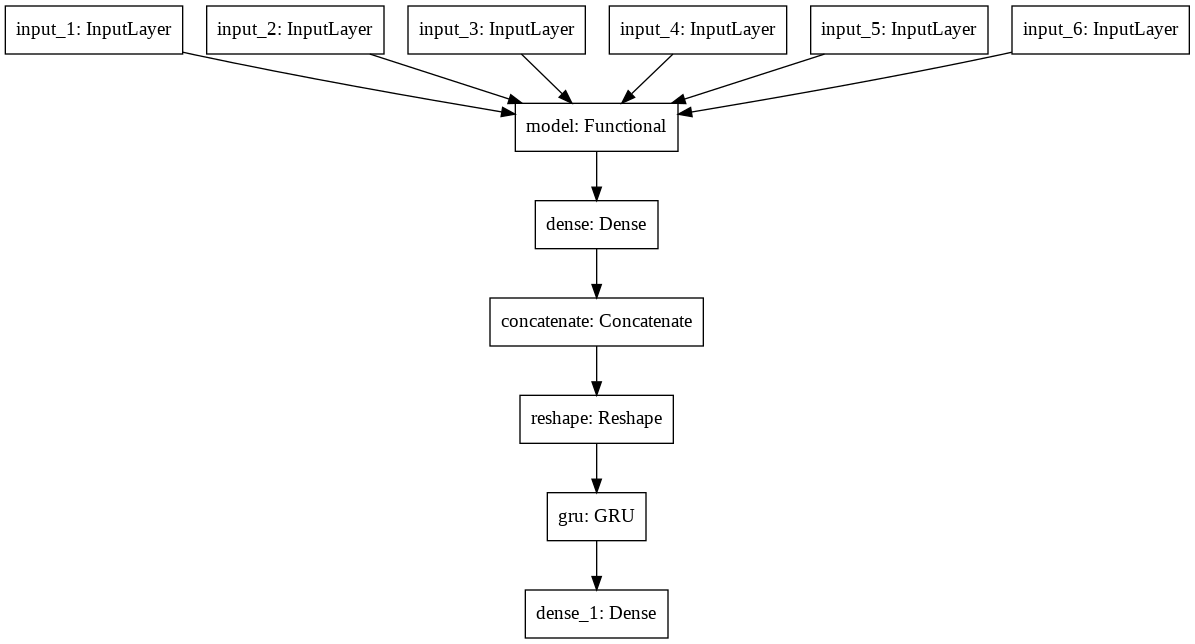

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model) #, to_file='/content/drive/Shareddrives/Final Year Project/CS 2/model.png')

In [ ]:
#Reference: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
# In the neural network terminology:

# one epoch = one forward pass and one backward pass of all the training examples
# batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
# number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
# Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

In [ ]:
#Train with a portion of the training data first 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#Kuo: adam optimizer, 10000 iter, 2000 epochs, best validation accuracy , fixed learning rate =  0.01

#Compile

earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint(filepath='/content/drive/Shareddrives/Final Year Project/CS 2/Deep Learning/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, monitor='val_loss', mode='min')

model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Fit# Kuo: adam optimizer, 10000 iter, 2000 epochs, best validation accuracy , fixed learning rate =  0.01

# Compile

earlyStopping = EarlyStopping(monitor='accuracy', patience=3, verbose=0, mode='max')
mcp_save = ModelCheckpoint(filepath='Models/checkpoint-{epoch:02d}-{accuracy:.2f}.hdf5', save_best_only=True, monitor='accuracy', mode='max')

model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Fit  (, steps_per_epoch=trainGenerator.step_ep) omitted this <- (Another version of progress bar: TqdmCallback(verbose=2))
history = model.fit(x = trainBatches, validation_data = validationBatches, epochs = 10,verbose=1, callbacks=[earlyStopping, mcp_save], steps_per_epoch=trainGenerator.step_ep)

test_loss, test_acc = model.evaluate(testBatches, verbose=1)
print("Test acc is {}".format(test_acc))

model.save('Models/savedManually.h5')
history = model.fit(x = trainBatches, validation_data = validationBatches, epochs = 10,verbose=1, callbacks=[earlyStopping, mcp_save], steps_per_epoch=trainGenerator.step_ep, use_multiprocessing= True)

test_loss, test_acc = model.evaluate(testBatches, verbose=1)
print("Test acc is {}".format(test_acc))

model.save('/content/drive/Shareddrives/Final Year Project/CS 2/Deep Learning/SavedManually/savedModel.h5')

In [ ]:
#Plotting
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], label='train accuracy', color='green', marker="o")
ax1.plot(history.history['val_accuracy'], label='valid accuracy', color='blue', marker = "v")
ax2.plot(history.history['loss'], label = 'train loss', color='orange', marker="o")
ax2.plot(history.history['val_loss'], label = 'valid loss', color='red', marker = "v")
ax1.legend(loc=3)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Loss', color='b')
ax2.legend(loc=4)
plt.ylim([0.6, 2.5])
plt.show()

After the training, we can load the best saved model and perform fine tuning. 

Potential drawbacks:

1.   Not using grayscale images
2.   Not standardizing the images (divide by certain value)
3.  Have not done Principle Component Analysis.
4. Did not use Weight initializer for the layers.
5. Did not remove non peak expressions.